In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyreadr
import glob

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
pandas2ri.activate()

# To remove an annoying warning from R (point it to the R libpath)
import rpy2.rinterface
from rpy2.robjects.packages import importr
xgboost = importr('xgboost', lib_loc = "~/R/x86_64-redhat-linux-gnu-library/3.6") # R version depdendency here!!
import json
import random
import sys, os, re

plt.rcParams.update({"text.usetex": True,})

In [2]:
def readShapR(rds_list):
    df_shap = pd.DataFrame()
    readRDS = robjects.r['readRDS']

    for filename in rds_list:
        with localconverter(robjects.default_converter + pandas2ri.converter):
            df = robjects.conversion.rpy2py(readRDS(filename))
        if df_shap.empty:
            df_shap = df[0].abs()
        else:
            df_shap = df_shap + df[0].abs()

    df_abs = pd.DataFrame((df_shap/len(rds_list)/df_shap.shape[0]).sum()).iloc[1:].sort_values(by=0, ascending=True)
    return df_abs

def assert_nesting(lst):
    safe_lst = []
    for _elem in lst:
        if not isinstance(_elem, list):
            safe_lst.append([_elem])
        else: safe_lst.append(_elem)
    return safe_lst
        
def nested_indices(lst, elem):
    """"For once nested lists. Returns tuple with outer and inner index of elem in lst"""
    lst = assert_nesting(lst)
    return [(index1, index2) for index1, value1 in enumerate(lst) 
            for index2,value2 in enumerate(value1) if value2==elem][0]


def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, s=20, c='b', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, hold=None, **kwargs):
    return plt.scatter(rand_jitter(x), y, s=s, c=c, marker=marker, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha, linewidths=linewidths, **kwargs)


def find_causal_and_shap_indices(jsonfile):
    # Find identifier
    identifier = re.search(r'configurations_(.*?)\.json', jsonfile).group(1)
    
    with open(os.path.join(base_dir, jsonfile),) as _openfile:
        _data = json.load(_openfile)
        po = _data["partial_order"]
        
        # Index of features [1,2,...,13] in causal ordering:
        causal_indices = [nested_indices(po, _f)[0] for _f in all_feats]
        
        # Find index in SHAP values for all features
        shapdir = f"{base_dir}/causality_{identifier}/*.rds"
        shap_df = readShapR(glob.glob(shapdir))
        sorted_feats = list(shap_df.index)
        sorted_feats.reverse()
        sorted_feats_num = [index_feature[_f] for _f in sorted_feats]
        # Index of features [1,2,...,13] in sorted SHAP values:
        shap_indices = [sorted_feats_num.index(_f) for _f in all_feats]
        
    return identifier, causal_indices, shap_indices

## Gather info from config files

In [3]:
#TODO: confirm with Ayan
feature_index = {
    1:"Non.White", 2:"Senior.Citizen", 3:"Employed", 4:"Unemployment", 
    5:"Income", 6:"Labor", 7:"Uninsured", 8:"Comorbidities", 9:"Poverty", 
    10:"Gini", 11:"Density", 12:"Mean.Commute", 13:"Transit"}

index_feature = inv_dict = dict(zip(feature_index.values(), feature_index.keys()))
all_feats = list(range(1,14))

In [4]:
base_dir = "../results/R-V1/Random_partial_ordering-2021-06-01"

identifiers, correlations = [], []
all_shap_indices = []

for _file in os.listdir(base_dir):
    if not _file.endswith(".json"):
        continue
    _id, _i_causal, _i_shap = find_causal_and_shap_indices(_file)
    all_shap_indices.append(_i_shap)
    
    # Calculate the Pearson correlation between causal and SHAP indices
    _r = np.corrcoef(_i_causal, _i_shap)[0][1]
    
    identifiers.append(_id)
    correlations.append(_r)

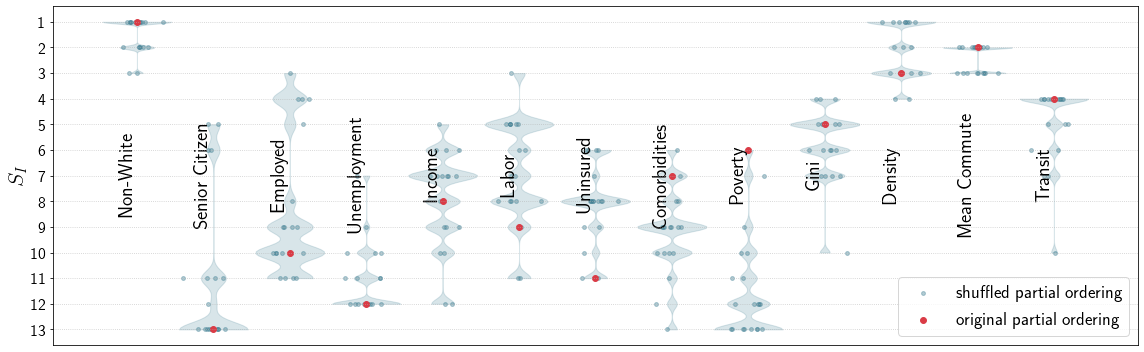

In [5]:
vals = np.array(all_shap_indices)

plt.figure(figsize=(16,5))

x_vals = []
y_vals = []

for val in vals:
    x_vals += list(range(1,14))
    y_vals += list(val)

x_vals = np.array(x_vals)
y_vals = np.array(y_vals)

jitter(x_vals[13:], y_vals[13:], c='#3f7f93', alpha=0.4, s=15, label='shuffled partial ordering')

vals = np.concatenate([vals]*5000)

ax = plt.gca()
parts = ax.violinplot(vals,
              widths=0.9,
              showextrema=False,
              showmeans=False,
             )

for pc in parts['bodies']:
    pc.set_facecolor('#3f7f93')
    pc.set_edgecolor('#3f7f93')
    pc.set_alpha(0.2)
    
plt.scatter(x_vals[:13], y_vals[:13], c='#da3b46', alpha=1, s=35, label='original partial ordering')

ax.invert_yaxis()
ax.set_xticks(list(set(feature_index)))
ax.set_xticklabels([feature_index[_i].replace(".W", "-W").replace(".C", " C")+"\n" for _i in all_feats],
                   rotation="vertical", fontsize=20, fontdict={'verticalalignment': 'center'}, zorder=99)

ax.set_yticks(list(range(13)))
ax.set_yticklabels([_i for _i in all_feats], fontsize=16)
ax.tick_params(axis="x", direction="in", pad=-170, length=0)

ax.grid(linestyle=':', axis='y', alpha=0.7)
plt.legend(loc='lower right', fontsize=18)
plt.ylabel(r"$S_I$", fontsize=22)
plt.tight_layout()
plt.savefig('../plots/random-ordering.pdf', dpi=300)
plt.show()